In [1]:
!wget -q https://raw.githubusercontent.com/sizhky/deep-fake-util/main/random_warp.py
from IPython.display import clear_output
from google.colab import files
files.upload()
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d atulanandjha/lfwpeople
!unzip lfwpeople.zip
!tar -xvzf lfw-funneled.tgz
!rm lfw-funneled.tgz lfwpeople.zip
clear_output()

In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torchvision import transforms as T

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from glob import glob
from tqdm.notebook import trange, tqdm

from random_warp import get_training_data

In [3]:
img_dir = glob('lfw_funneled/'+'/*/*')
img_dir = [str(x) for x in img_dir]
df = pd.DataFrame(img_dir, columns=['Image_dir'])
df['Name'] = df['Image_dir'].str.split('/', expand=True).loc[:, [1,]]
df.sample(5)

,Image_dir,Name
11318,lfw_funneled/George_W_Bush/George_W_Bush_0248.jpg,George_W_Bush
7741,lfw_funneled/Stanislas_Wawrinka/Stanislas_Wawr...,Stanislas_Wawrinka
7361,lfw_funneled/Gisele_Bundchen/Gisele_Bundchen_0...,Gisele_Bundchen
6529,lfw_funneled/Eurico_Guterres/Eurico_Guterres_0...,Eurico_Guterres
8819,lfw_funneled/Mahmoud_Abbas/Mahmoud_Abbas_0004.jpg,Mahmoud_Abbas


In [4]:
bush_data = df[df.Name == 'George_W_Bush']
powel_data = df[df.Name == 'Colin_Powell']

In [5]:
train_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((256, 256)),
                              T.ColorJitter(brightness=(0.9, 1.1),
                                            contrast=(0.9, 1.1),
                                            saturation=(0.9, 1.1),
                                            hue=0.25),
                              T.RandomAffine(10, (0.1, 0.3), scale=(0.75, 1.35), shear=30),  
                              T.RandomHorizontalFlip(p=0.5),
                              T.RandomVerticalFlip(p=0.2),
                              T.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2)),
                              T.RandomAdjustSharpness(sharpness_factor=1.2, p=0.2),
                              T.RandomRotation(degrees=(-15, 15)),
                              #T.ToTensor(),
])

In [6]:
torch.random.manual_seed(123)

IMAGE_SIZE = 256
BATCH_SIZE = 16
epochs = 200
PATH = r'/content/drive/My Drive/data/swap_model.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def crop_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    if len(faces) > 0:
        for x, y, w, h in faces:
            image2 = image[y: y+h, x: x+w, :]
        image2 = cv2.resize(image2, (IMAGE_SIZE, IMAGE_SIZE))
        return image2, 1
    return image, 0

In [8]:
# get cropped faces
bush_images, powel_images = [], []
for dataset in [bush_data, powel_data]:
    name = dataset.iloc[0,1]
    for path in dataset['Image_dir'].values:
        img = cv2.imread(path)
        img, is_detected = crop_face(img)
        if is_detected:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if name == 'George_W_Bush':
                bush_images.append(img)
            else:
                powel_images.append(img)
        else:
            continue
bush_images = np.array(bush_images)
powel_images = np.array(powel_images)

In [9]:
random_transform_args = {
    'rotation_range': 10,
    'zoom_range': 0.05,
    'shift_range': 0.05,
    'random_flip': 0.4,
}

def get_training_data1(images, batch_size):
    indices = np.random.randint(len(images), size=batch_size)
    for i, index in enumerate(indices):
        image = images[index]
        image = random_transform(image, **random_transform_args)
        warped_img, target_img = random_warp(image)

        if i == 0:
            warped_images = np.empty((batch_size,) + warped_img.shape, warped_img.dtype)
            target_images = np.empty((batch_size,) + target_img.shape, warped_img.dtype)

        warped_images[i] = warped_img
        target_images[i] = target_img

    return warped_images, target_images

def random_transform(image, rotation_range, zoom_range, shift_range, random_flip):
    h, w = image.shape[0:2]
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - zoom_range, 1 + zoom_range)
    tx = np.random.uniform(-shift_range, shift_range) * w
    ty = np.random.uniform(-shift_range, shift_range) * h
    mat = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)
    mat[:, 2] += (tx, ty)
    result = cv2.warpAffine(image, mat, (w, h), borderMode=cv2.BORDER_REPLICATE)
    if np.random.random() < random_flip:
        result = result[:, ::-1]
    return result

def random_warp(image):
    assert image.shape == (256, 256, 3)
    range_ = np.linspace(128 - 80, 128 + 80, 5)
    mapx = np.broadcast_to(range_, (5, 5))
    mapy = mapx.T

    mapx = mapx + np.random.normal(size=(5, 5), scale=5)
    mapy = mapy + np.random.normal(size=(5, 5), scale=5)

    interp_mapx = cv2.resize(mapx, (80, 80))[8:72, 8:72].astype('float32')
    interp_mapy = cv2.resize(mapy, (80, 80))[8:72, 8:72].astype('float32')

    warped_image = cv2.remap(image, interp_mapx, interp_mapy, cv2.INTER_LINEAR)

    src_points = np.stack([mapx.ravel(), mapy.ravel()], axis=-1)
    dst_points = np.mgrid[0:65:16, 0:65:16].T.reshape(-1, 2)
    mat = umeyama(src_points, dst_points, True)[0:2]

    target_image = cv2.warpAffine(image, mat, (64, 64))

    return warped_image, target_image


def umeyama(src, dst, estimate_scale):

    num = src.shape[0]
    dim = src.shape[1]

    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    src_demean = src - src_mean
    dst_demean = dst - dst_mean

    A = np.dot(dst_demean.T, src_demean) / num

    d = np.ones((dim,), dtype=np.double)
    if np.linalg.det(A) < 0:
        d[dim - 1] = -1

    T = np.eye(dim + 1, dtype=np.double)

    U, S, V = np.linalg.svd(A)

    rank = np.linalg.matrix_rank(A)
    if rank == 0:
        return np.nan * T
    elif rank == dim - 1:
        if np.linalg.det(U) * np.linalg.det(V) > 0:
            T[:dim, :dim] = np.dot(U, V)
        else:
            s = d[dim - 1]
            d[dim - 1] = -1
            T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))
            d[dim - 1] = s
    else:
        T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V.T))

    if estimate_scale:
        scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
    else:
        scale = 1.0

    T[:dim, dim] = dst_mean - scale * np.dot(T[:dim, :dim], src_mean.T)
    T[:dim, :dim] *= scale

    return T

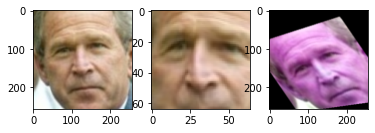

In [ ]:
img = cv2.imread(bush_data.iloc[0,0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, _ = crop_face(img)
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
simg = cv2.resize(img, (256,256))
simg = simg[None, ...]
simg = get_training_data1(simg, 1)[0]
plt.imshow(simg.squeeze())
plt.subplot(133)
timg = train_transforms(img) # without totensor and normalize
plt.imshow(timg)
plt.show()

In [10]:
class SwapDataset(torch.utils.data.Dataset):
    def __init__(self, dataA, dataB):
        self.dataA = np.concatenate([face[None] for face in dataA])/255.
        self.dataB = np.concatenate([face[None] for face in dataB])/255.
        self.dataA += self.dataB.mean(axis=(0,1,2)) - self.dataA.mean(axis=(0,1,2))

    def __len__(self):
        return min(len(self.dataA), len(self.dataB))

    def __getitem__(self, ix):
        imgA, imgB = self.dataA[np.random.randint(len(self.dataA))], self.dataB[np.random.randint(len(self.dataB))]
        return imgA, imgB

    def collate_fn(self, batch):
        imgsA, imgsB = list(zip(*batch))
        imgsA, targetA = get_training_data1(imgsA, len(imgsA))
        imgsB, targetB = get_training_data1(imgsB, len(imgsB))
        imgsA, imgsB, targetA, targetB = [torch.Tensor(i).permute(0,3,1,2).to(device) for i in [imgsA, imgsB, targetA, targetB]]
        return imgsA, imgsB, targetA, targetB

In [11]:
dataset = SwapDataset(bush_images, powel_images)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn)

In [12]:
def _ConvLayer(input_features, output_features):
    return nn.Sequential(
        nn.Conv2d(input_features, output_features, kernel_size=5, stride=2, padding=2),
        nn.LeakyReLU(0.1, inplace=True)
    )

def _UpScale(input_features, output_features):
    return nn.Sequential(
        nn.ConvTranspose2d(input_features, output_features, kernel_size=2, stride=2, padding=0),
        nn.LeakyReLU(0.1, inplace=True)
    )

class Reshape(nn.Module):
    def forward(self, x):
        return x.view(-1, 1024, 4, 4)

class SwapCoder(nn.Module):
    def __init__(self):
        super(SwapCoder, self).__init__()
        self.encoder = nn.Sequential(
            _ConvLayer(3, 128),
            _ConvLayer(128, 256),
            _ConvLayer(256, 512),
            _ConvLayer(512, 1024),
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1024),
            nn.Linear(1024, 1024 * 4 * 4),
            Reshape(),
            _UpScale(1024, 512),
        )

        self.decoderA = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

        self.decoderB = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, select='A'):
        out = self.encoder(x)
        if select == 'A':
            out = self.decoderA(out)
        else:
            out = self.decoderB(out)
        return out

# try later with reparametrize and discriminator
# https://www.kaggle.com/carloalbertobarbano/faceswap-trump-in-a-cage

In [13]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path=PATH):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss, epoch=None, model=None, optimizerA=None, 
                 optimizerB=None, schedulerA=None, schedulerB=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = { 
                          'epoch': epoch,
                          'model': model,
                          'optimizerA': optimizerA,
                          'optimizerB': optimizerB,
                          'schedulerA': schedulerA,
                          'schedulerB': schedulerB,
                          'early': self,
                          }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

def load_model(path):
    checkpoint = torch.load(path)
    epoch = checkpoint['epoch']
    model = checkpoint['model']
    optimizerA = checkpoint['optimizerA']
    optimizerB = checkpoint['optimizerB']
    schedulerA = checkpoint['schedulerA']
    schedulerB = checkpoint['schedulerB']
    early = checkpoint['early']
    return model, optimizerA, optimizerB, epoch, schedulerA, schedulerB, early 

In [14]:
model = SwapCoder().to(device)

from torchsummary import summary
summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           9,728
         LeakyReLU-2          [-1, 128, 32, 32]               0
            Conv2d-3          [-1, 256, 16, 16]         819,456
         LeakyReLU-4          [-1, 256, 16, 16]               0
            Conv2d-5            [-1, 512, 8, 8]       3,277,312
         LeakyReLU-6            [-1, 512, 8, 8]               0
            Conv2d-7           [-1, 1024, 4, 4]      13,108,224
         LeakyReLU-8           [-1, 1024, 4, 4]               0
           Flatten-9                [-1, 16384]               0
           Linear-10                 [-1, 1024]      16,778,240
           Linear-11                [-1, 16384]      16,793,600
          Reshape-12           [-1, 1024, 4, 4]               0
  ConvTranspose2d-13            [-1, 512, 8, 8]       2,097,664
        LeakyReLU-14            [-1, 51

In [15]:
def plot_face(model, img):
    img_ = cv2.resize(img, (64,64))
    img_ = torch.Tensor(img_[None]/255.).permute(0,3,1,2).to(device)
    imgA_ = model(img_, 'A')
    imgB_ = model(img_, 'B')
    imgA_ = imgA_[0].cpu().detach().numpy().transpose(1,2,0)
    imgB_ = imgB_[0].cpu().detach().numpy().transpose(1,2,0)
    plt.figure(figsize=(8,8))
    plt.subplot(131)
    plt.title('Original')
    plt.imshow(img)
    plt.subplot(132)
    plt.title('Reconstructed original')
    plt.imshow(imgA_)
    plt.subplot(133)
    plt.title('Reconstructed fake')
    plt.imshow(imgB_)
    plt.show()
    plt.pause(0.001)

In [16]:
def train_one_batch(model, data, criterion, optimizers):
    model.train()
    optA, optB = optimizers
    optA.zero_grad()
    optB.zero_grad()
    imgsA, imgsB, targetA, targetB = data
    _imgsA, _imgsB = model(imgsA, 'A'), model(imgsB, 'B')
    lossA = criterion(_imgsA, targetA)
    lossB = criterion(_imgsB, targetB)
    lossA.backward()
    lossB.backward()
    optA.step()
    optB.step()
    return lossA.item(), lossB.item()

In [24]:
criterion = nn.L1Loss()
optimizerA = torch.optim.Adam([{'params': model.encoder.parameters()},
                               {'params': model.decoderA.parameters()}], lr=5e-5, betas=(0.5, 0.999))  # 5e-5
optimizerB = torch.optim.Adam([{'params': model.encoder.parameters()},
                               {'params': model.decoderB.parameters()}], lr=5e-5, betas=(0.5, 0.999))  # 5e-5
schedulerA = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerA, patience=5, min_lr=5e-8, factor=0.1)
schedulerB = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerB, patience=5, min_lr=5e-8, factor=0.1)

early = EarlyStopping(patience=20) # input sum of lossA + lossB

In [23]:
model, optimizerA, optimizerB, _, schedulerA, schedulerB, early = load_model(PATH)

Epoch 1/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0587, Epoch B loss: 0.0603, total: 0.1190
--------------------------------------------------
Epoch 2/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0572, Epoch B loss: 0.0616, total: 0.1188
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/swap_model.pth
Epoch 3/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0577, Epoch B loss: 0.0620, total: 0.1197
--------------------------------------------------
INFO: Early stopping counter 1 of 20
Epoch 4/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0597, Epoch B loss: 0.0609, total: 0.1206
--------------------------------------------------
INFO: Early stopping counter 2 of 20
Epoch 5/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0590, Epoch B loss: 0.0627, total: 0.1217
--------------------------------------------------
INFO: Early stopping counter 3 of 20
Epoch 6/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0586, Epoch B loss: 0.0587, total: 0.1173
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/swap_model.pth
Epoch 7/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0588, Epoch B loss: 0.0617, total: 0.1204
--------------------------------------------------
INFO: Early stopping counter 1 of 20
Epoch 8/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0592, Epoch B loss: 0.0609, total: 0.1201
--------------------------------------------------
INFO: Early stopping counter 2 of 20
Epoch 9/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0573, Epoch B loss: 0.0595, total: 0.1168
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/swap_model.pth
Epoch 10/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0560, Epoch B loss: 0.0572, total: 0.1133
--------------------------------------------------


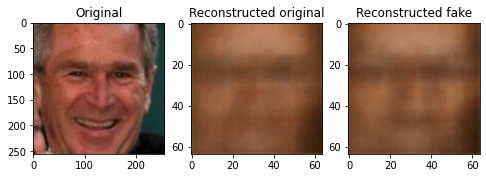

Model saved to: /content/drive/My Drive/data/swap_model.pth
Epoch 11/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0552, Epoch B loss: 0.0583, total: 0.1136
--------------------------------------------------
INFO: Early stopping counter 1 of 20
Epoch 12/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0553, Epoch B loss: 0.0591, total: 0.1145
--------------------------------------------------
INFO: Early stopping counter 2 of 20
Epoch 13/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0557, Epoch B loss: 0.0574, total: 0.1131
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/swap_model.pth
Epoch 14/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0551, Epoch B loss: 0.0573, total: 0.1124
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/swap_model.pth
Epoch 15/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0537, Epoch B loss: 0.0588, total: 0.1125
--------------------------------------------------
INFO: Early stopping counter 1 of 20
Epoch 16/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0554, Epoch B loss: 0.0569, total: 0.1123
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/swap_model.pth
Epoch 17/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0521, Epoch B loss: 0.0594, total: 0.1116
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/swap_model.pth
Epoch 18/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0563, Epoch B loss: 0.0576, total: 0.1138
--------------------------------------------------
INFO: Early stopping counter 1 of 20
Epoch 19/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0575, Epoch B loss: 0.0581, total: 0.1156
--------------------------------------------------
INFO: Early stopping counter 2 of 20
Epoch 20/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0554, Epoch B loss: 0.0578, total: 0.1132
--------------------------------------------------


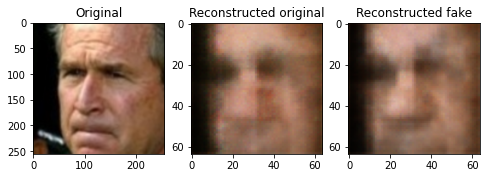

INFO: Early stopping counter 3 of 20
Epoch 21/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0555, Epoch B loss: 0.0568, total: 0.1123
--------------------------------------------------
INFO: Early stopping counter 4 of 20
Epoch 22/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0551, Epoch B loss: 0.0549, total: 0.1100
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/swap_model.pth
Epoch 23/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0561, Epoch B loss: 0.0550, total: 0.1111
--------------------------------------------------
INFO: Early stopping counter 1 of 20
Epoch 24/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0537, Epoch B loss: 0.0581, total: 0.1119
--------------------------------------------------
INFO: Early stopping counter 2 of 20
Epoch 25/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0534, Epoch B loss: 0.0572, total: 0.1106
--------------------------------------------------
INFO: Early stopping counter 3 of 20
Epoch 26/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0547, Epoch B loss: 0.0571, total: 0.1118
--------------------------------------------------
INFO: Early stopping counter 4 of 20
Epoch 27/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0554, Epoch B loss: 0.0555, total: 0.1108
--------------------------------------------------
INFO: Early stopping counter 5 of 20
Epoch 28/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0566, Epoch B loss: 0.0568, total: 0.1134
--------------------------------------------------
INFO: Early stopping counter 6 of 20
Epoch 29/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0514, Epoch B loss: 0.0545, total: 0.1059
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/swap_model.pth
Epoch 30/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0533, Epoch B loss: 0.0551, total: 0.1085
--------------------------------------------------


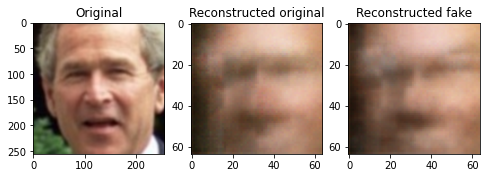

INFO: Early stopping counter 1 of 20
Epoch 31/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0527, Epoch B loss: 0.0553, total: 0.1080
--------------------------------------------------
INFO: Early stopping counter 2 of 20
Epoch 32/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0537, Epoch B loss: 0.0563, total: 0.1099
--------------------------------------------------
INFO: Early stopping counter 3 of 20
Epoch 33/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0544, Epoch B loss: 0.0542, total: 0.1086
--------------------------------------------------
INFO: Early stopping counter 4 of 20
Epoch 34/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0541, Epoch B loss: 0.0540, total: 0.1080
--------------------------------------------------
INFO: Early stopping counter 5 of 20
Epoch 35/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0520, Epoch B loss: 0.0558, total: 0.1079
--------------------------------------------------
INFO: Early stopping counter 6 of 20
Epoch 36/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0519, Epoch B loss: 0.0561, total: 0.1080
--------------------------------------------------
INFO: Early stopping counter 7 of 20
Epoch 37/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0548, Epoch B loss: 0.0563, total: 0.1111
--------------------------------------------------
INFO: Early stopping counter 8 of 20
Epoch 38/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0551, Epoch B loss: 0.0565, total: 0.1116
--------------------------------------------------
INFO: Early stopping counter 9 of 20
Epoch 39/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0539, Epoch B loss: 0.0541, total: 0.1080
--------------------------------------------------
INFO: Early stopping counter 10 of 20
Epoch 40/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0539, Epoch B loss: 0.0540, total: 0.1079
--------------------------------------------------


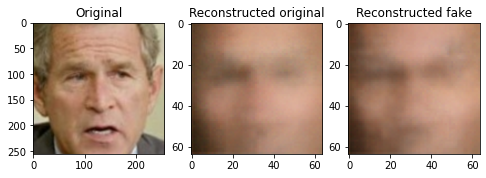

INFO: Early stopping counter 11 of 20
Epoch 41/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0534, Epoch B loss: 0.0550, total: 0.1083
--------------------------------------------------
INFO: Early stopping counter 12 of 20
Epoch 42/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0536, Epoch B loss: 0.0556, total: 0.1092
--------------------------------------------------
INFO: Early stopping counter 13 of 20
Epoch 43/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0542, Epoch B loss: 0.0537, total: 0.1079
--------------------------------------------------
INFO: Early stopping counter 14 of 20
Epoch 44/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0532, Epoch B loss: 0.0537, total: 0.1068
--------------------------------------------------
INFO: Early stopping counter 15 of 20
Epoch 45/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0544, Epoch B loss: 0.0551, total: 0.1095
--------------------------------------------------
INFO: Early stopping counter 16 of 20
Epoch 46/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0544, Epoch B loss: 0.0540, total: 0.1084
--------------------------------------------------
INFO: Early stopping counter 17 of 20
Epoch 47/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0541, Epoch B loss: 0.0559, total: 0.1100
--------------------------------------------------
INFO: Early stopping counter 18 of 20
Epoch 48/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0533, Epoch B loss: 0.0558, total: 0.1091
--------------------------------------------------
INFO: Early stopping counter 19 of 20
Epoch 49/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch A loss: 0.0538, Epoch B loss: 0.0551, total: 0.1089
--------------------------------------------------
INFO: Early stopping counter 20 of 20
INFO: Early stopping
Validation loss did not improve for 20 epochs. Training stopped.


In [25]:
lossesA, lossesB = [], []

for epoch in range(epochs):

    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_A_losses, epoch_B_losses = [], []

    for _, batch in enumerate(tqdm(dataloader, leave=False)):
        batch_A_loss, batch_B_loss = train_one_batch(model, batch, criterion, (optimizerA, optimizerB))
        epoch_A_losses.append(batch_A_loss)
        epoch_B_losses.append(batch_B_loss)
    epoch_A_loss = np.array(epoch_A_losses).mean()
    epoch_B_loss = np.array(epoch_B_losses).mean()
    lossesA.append(epoch_A_loss)
    lossesB.append(epoch_B_loss)
    print(f'Epoch A loss: {epoch_A_loss:.4f}, Epoch B loss: {epoch_B_loss:.4f}, total: {epoch_A_loss+epoch_B_loss:.4f}')
    print('-'*50)

    if (epoch+1) % 10 == 0:
        plot_face(model, bush_images[np.random.randint(len(bush_images))])     

    schedulerA.step(epoch_A_loss)
    schedulerB.step(epoch_B_loss)
    early(epoch_A_loss+epoch_B_loss, epoch=epoch, model=model, optimizerA=optimizerA, optimizerB=optimizerB,
          schedulerA=schedulerA, schedulerB=schedulerB)
    if early.early_stop:
        print(f'Validation loss did not improve for {early.patience} epochs. Training stopped.')
        model, optimizerA, optimizerB, epoch, schedulerA, schedulerB, early = load_model(PATH)
        break

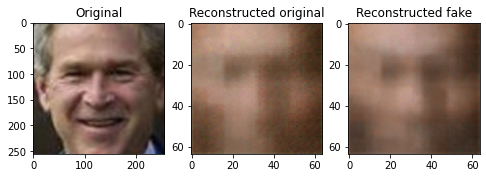

In [ ]:
plot_face(model, bush_images[0])